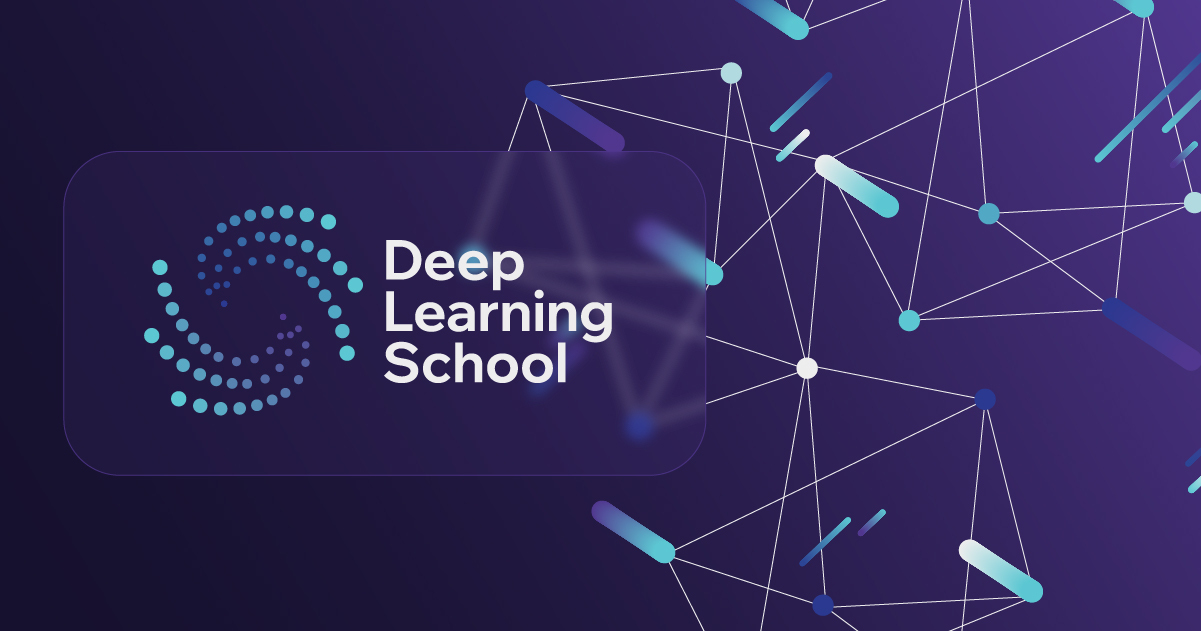

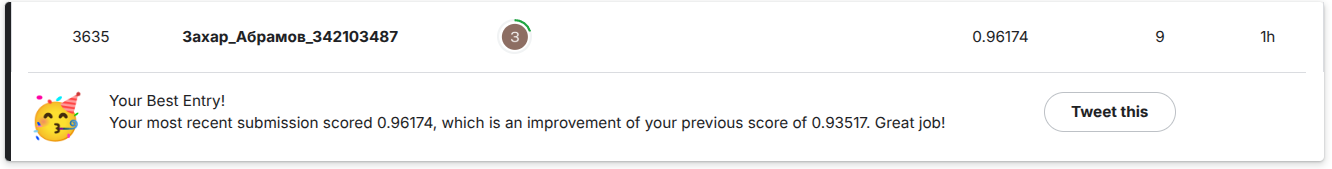


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


ВНИМАНИЕ: Тут поменял команду

In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d ./data

In [ ]:
!ls train

ls: cannot access 'train': No such file or directory


In [ ]:
!ls data

characters_illustration.png  sample_submission.csv  testset  train


In [ ]:
!ls data/train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 12 10:55:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [ ]:
!python --version

Python 3.11.12


In [ ]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
tqdm version: 4.67.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
Pillow version: 11.1.0


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [ ]:

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip()
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./data/train/')
TEST_DIR = Path('./data/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

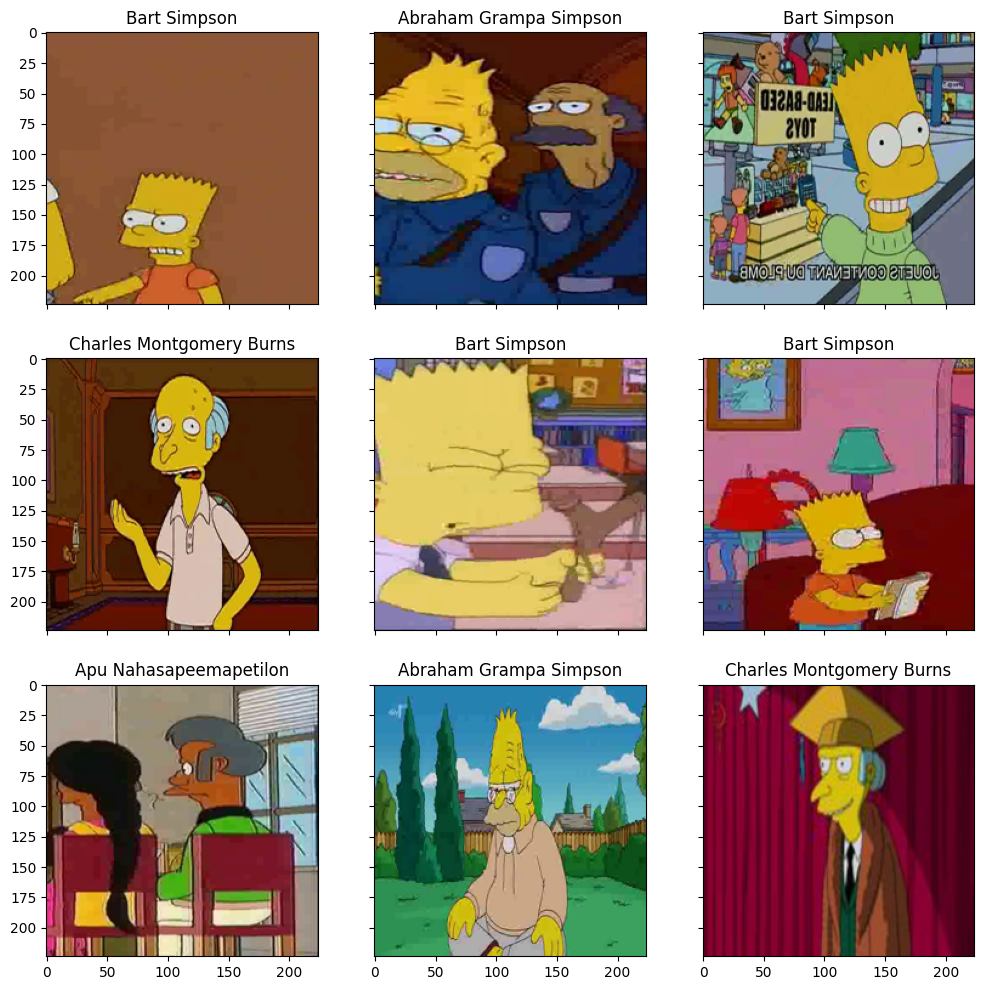

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [ ]:
# class SimpleCnn(nn.Module):
#     """
#     Очень простая сверточная нейронная сеть для классификации изображений.

#     Эта сеть состоит из пяти сверточных слоев, каждый из которых
#     включает в себя операцию свертки, функцию активации ReLU и операцию
#     пулинга (max-pooling). На выходе используется полносвязный слой
#     для классификации на заданное количество классов.

#     Параметры:
#     ----------
#     n_classes : int
#         Количество классов для классификации.

#     Примечание:
#     ----------
#     Входные изображения должны иметь размерность (3, H, W), где
#     3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
#     соответственно. Размер выходного тензора будет равен (n_classes).

#     Методы:
#     -------
#     forward(x):
#         Пропускает входные данные через сеть и возвращает логиты для
#         каждого класса.
#     """

#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.out = nn.Linear(96 * 5 * 5, n_classes)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits

In [ ]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(96 * 5 * 5, 1200)
        self.act1 = nn.ELU()
        self.fc2 = nn.Linear(1200, 600)
        self.act2 = nn.ELU()
        self.fc3 = nn.Linear(600, 300)
        self.act3 = nn.ELU()
        self.out = nn.Linear(300, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        logits = self.out(x)
        return logits

#### Функция обучения:

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [ ]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [ ]:
from collections import Counter

counter = Counter([path.parent.name for path in val_files])
weights = map(
    lambda path : counter[path.parent.name] / len(val_files),
    val_files
    )
weights = np.array(list(weights))
sampler = WeightedRandomSampler(torch.from_numpy(weights), len(weights))

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [ ]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): 

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=256)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5355108730839464


epoch:  50%|█████     | 1/2 [01:03<01:03, 63.73s/it]


Epoch 001 train_loss: 2.5355     val_loss 6.2534 train_acc 0.1620 val_acc 0.0642
loss 2.163240336214808


epoch: 100%|██████████| 2/2 [02:05<00:00, 62.63s/it]


Epoch 002 train_loss: 2.1632     val_loss 5.4704 train_acc 0.2493 val_acc 0.1204


In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=512)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.184674873942403


epoch:  10%|█         | 1/10 [01:04<09:40, 64.50s/it]


Epoch 001 train_loss: 2.1847     val_loss 6.5470 train_acc 0.2891 val_acc 0.0951
loss 1.9586255142695128


epoch:  20%|██        | 2/10 [02:09<08:38, 64.77s/it]


Epoch 002 train_loss: 1.9586     val_loss 6.0587 train_acc 0.3584 val_acc 0.1301
loss 1.7273525949830904


epoch:  30%|███       | 3/10 [03:13<07:31, 64.55s/it]


Epoch 003 train_loss: 1.7274     val_loss 6.4247 train_acc 0.4398 val_acc 0.1477
loss 1.5725786526056478


epoch:  40%|████      | 4/10 [04:16<06:22, 63.81s/it]


Epoch 004 train_loss: 1.5726     val_loss 6.8951 train_acc 0.4861 val_acc 0.1861
loss 1.3603857948345495


epoch:  50%|█████     | 5/10 [05:18<05:15, 63.13s/it]


Epoch 005 train_loss: 1.3604     val_loss 7.0237 train_acc 0.5636 val_acc 0.2121
loss 1.1545528500053688


epoch:  60%|██████    | 6/10 [06:22<04:13, 63.37s/it]


Epoch 006 train_loss: 1.1546     val_loss 7.7108 train_acc 0.6274 val_acc 0.2174
loss 1.097627726296318


epoch:  70%|███████   | 7/10 [07:25<03:10, 63.41s/it]


Epoch 007 train_loss: 1.0976     val_loss 8.0830 train_acc 0.6601 val_acc 0.2390
loss 0.9779284099699843


epoch:  80%|████████  | 8/10 [08:30<02:07, 63.79s/it]


Epoch 008 train_loss: 0.9779     val_loss 7.7146 train_acc 0.7025 val_acc 0.2635
loss 0.8623141364419009


epoch:  90%|█████████ | 9/10 [09:34<01:03, 63.88s/it]


Epoch 009 train_loss: 0.8623     val_loss 8.4928 train_acc 0.7352 val_acc 0.2681
loss 0.8225612067565874


epoch: 100%|██████████| 10/10 [10:38<00:00, 63.83s/it]


Epoch 010 train_loss: 0.8226     val_loss 8.3230 train_acc 0.7486 val_acc 0.2912


In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=768)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.701185810552283


epoch:  10%|█         | 1/10 [01:05<09:51, 65.68s/it]


Epoch 001 train_loss: 1.7012     val_loss 8.6724 train_acc 0.5745 val_acc 0.2467
loss 1.1522336312728754


epoch:  20%|██        | 2/10 [02:12<08:49, 66.15s/it]


Epoch 002 train_loss: 1.1522     val_loss 7.1639 train_acc 0.6609 val_acc 0.2182
loss 0.9699298221963847


epoch:  30%|███       | 3/10 [03:17<07:40, 65.75s/it]


Epoch 003 train_loss: 0.9699     val_loss 7.4223 train_acc 0.6932 val_acc 0.2577
loss 0.8963003271765776


epoch:  40%|████      | 4/10 [04:22<06:32, 65.34s/it]


Epoch 004 train_loss: 0.8963     val_loss 8.0470 train_acc 0.7384 val_acc 0.2744
loss 0.8129783004214849


epoch:  50%|█████     | 5/10 [05:26<05:25, 65.05s/it]


Epoch 005 train_loss: 0.8130     val_loss 8.1008 train_acc 0.7547 val_acc 0.2805
loss 0.7235153213137655


epoch:  60%|██████    | 6/10 [06:31<04:20, 65.01s/it]


Epoch 006 train_loss: 0.7235     val_loss 8.7158 train_acc 0.7778 val_acc 0.2839
loss 0.7056310675414774


epoch:  70%|███████   | 7/10 [07:36<03:15, 65.11s/it]


Epoch 007 train_loss: 0.7056     val_loss 8.3231 train_acc 0.7872 val_acc 0.2958
loss 0.5921007399573598


epoch:  80%|████████  | 8/10 [08:41<02:09, 65.00s/it]


Epoch 008 train_loss: 0.5921     val_loss 9.2619 train_acc 0.8196 val_acc 0.3015
loss 0.5546800446136789


epoch:  90%|█████████ | 9/10 [09:49<01:05, 65.83s/it]


Epoch 009 train_loss: 0.5547     val_loss 9.6431 train_acc 0.8328 val_acc 0.2977
loss 0.48541831613771325


epoch: 100%|██████████| 10/10 [10:54<00:00, 65.44s/it]


Epoch 010 train_loss: 0.4854     val_loss 10.3420 train_acc 0.8550 val_acc 0.3045


In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=512)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.9064094414490182


epoch:  10%|█         | 1/10 [02:08<19:18, 128.74s/it]


Epoch 001 train_loss: 1.9064     val_loss 1.6133 train_acc 0.4779 val_acc 0.5623
loss 1.3508971206959177


epoch:  20%|██        | 2/10 [04:14<16:57, 127.21s/it]


Epoch 002 train_loss: 1.3509     val_loss 1.2877 train_acc 0.6311 val_acc 0.6473
loss 1.083154720343999


epoch:  30%|███       | 3/10 [06:21<14:49, 127.11s/it]


Epoch 003 train_loss: 1.0832     val_loss 1.0860 train_acc 0.6996 val_acc 0.7075
loss 0.9231445774150294


epoch:  40%|████      | 4/10 [08:29<12:42, 127.14s/it]


Epoch 004 train_loss: 0.9231     val_loss 0.9870 train_acc 0.7444 val_acc 0.7335
loss 0.7951993128434663


epoch:  50%|█████     | 5/10 [10:39<10:42, 128.46s/it]


Epoch 005 train_loss: 0.7952     val_loss 0.9543 train_acc 0.7793 val_acc 0.7382
loss 0.6871772451692041


epoch:  60%|██████    | 6/10 [12:47<08:32, 128.06s/it]


Epoch 006 train_loss: 0.6872     val_loss 0.8611 train_acc 0.8051 val_acc 0.7707
loss 0.5799092037889317


epoch:  70%|███████   | 7/10 [14:58<06:27, 129.02s/it]


Epoch 007 train_loss: 0.5799     val_loss 0.8961 train_acc 0.8370 val_acc 0.7618
loss 0.5174286770049125


epoch:  80%|████████  | 8/10 [17:18<04:25, 132.70s/it]


Epoch 008 train_loss: 0.5174     val_loss 0.8558 train_acc 0.8480 val_acc 0.7801
loss 0.4805596974011599


epoch:  90%|█████████ | 9/10 [19:34<02:13, 133.54s/it]


Epoch 009 train_loss: 0.4806     val_loss 0.7962 train_acc 0.8630 val_acc 0.7916
loss 0.4064779654282872


epoch: 100%|██████████| 10/10 [21:45<00:00, 130.57s/it]


Epoch 010 train_loss: 0.4065     val_loss 0.7796 train_acc 0.8823 val_acc 0.8057


In [ ]:
torch.save(simple_cnn.state_dict(), 'model.torch')

In [ ]:
simple_cnn.load_state_dict(torch.load('model.torch'))

<All keys matched successfully>

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=512)
torch.save(simple_cnn.state_dict(), 'model2.torch')
torch.save(simple_cnn.state_dict(), 'gdrive/Mydrive/model2.torch')

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.7588458422020185


epoch:   5%|▌         | 1/20 [02:10<41:26, 130.87s/it]


Epoch 001 train_loss: 0.7588     val_loss 0.5341 train_acc 0.7911 val_acc 0.8550
loss 0.43064568196370256


epoch:  10%|█         | 2/20 [04:17<38:33, 128.54s/it]


Epoch 002 train_loss: 0.4306     val_loss 0.4631 train_acc 0.8809 val_acc 0.8800
loss 0.3461849455985607


epoch:  15%|█▌        | 3/20 [06:22<35:57, 126.90s/it]


Epoch 003 train_loss: 0.3462     val_loss 0.4493 train_acc 0.9018 val_acc 0.8812
loss 0.3012371923150633


epoch:  20%|██        | 4/20 [08:28<33:41, 126.36s/it]


Epoch 004 train_loss: 0.3012     val_loss 0.4765 train_acc 0.9155 val_acc 0.8726
loss 0.27001946281988887


epoch:  25%|██▌       | 5/20 [10:33<31:26, 125.78s/it]


Epoch 005 train_loss: 0.2700     val_loss 0.4865 train_acc 0.9225 val_acc 0.8779
loss 0.23819322665107198


epoch:  30%|███       | 6/20 [12:40<29:27, 126.27s/it]


Epoch 006 train_loss: 0.2382     val_loss 0.5000 train_acc 0.9299 val_acc 0.8796
loss 0.219502099404609


epoch:  35%|███▌      | 7/20 [14:46<27:19, 126.12s/it]


Epoch 007 train_loss: 0.2195     val_loss 0.5007 train_acc 0.9355 val_acc 0.8815
loss 0.19848031462799312


epoch:  40%|████      | 8/20 [16:53<25:17, 126.47s/it]


Epoch 008 train_loss: 0.1985     val_loss 0.5378 train_acc 0.9403 val_acc 0.8695
loss 0.17283328107697424


epoch:  45%|████▌     | 9/20 [18:59<23:09, 126.32s/it]


Epoch 009 train_loss: 0.1728     val_loss 0.5937 train_acc 0.9469 val_acc 0.8729
loss 0.16076156319030585


epoch:  50%|█████     | 10/20 [21:06<21:06, 126.63s/it]


Epoch 010 train_loss: 0.1608     val_loss 0.5934 train_acc 0.9513 val_acc 0.8668
loss 0.12422594507603639


epoch:  55%|█████▌    | 11/20 [23:16<19:08, 127.63s/it]


Epoch 011 train_loss: 0.1242     val_loss 0.5783 train_acc 0.9620 val_acc 0.8771
loss 0.10995540442387157


epoch:  60%|██████    | 12/20 [25:24<17:01, 127.65s/it]


Epoch 012 train_loss: 0.1100     val_loss 0.6778 train_acc 0.9673 val_acc 0.8708
loss 0.10702007292421678


epoch:  65%|██████▌   | 13/20 [27:32<14:54, 127.84s/it]


Epoch 013 train_loss: 0.1070     val_loss 0.6534 train_acc 0.9666 val_acc 0.8626
loss 0.10013365585512854


epoch:  70%|███████   | 14/20 [29:41<12:49, 128.32s/it]


Epoch 014 train_loss: 0.1001     val_loss 0.7198 train_acc 0.9679 val_acc 0.8617
loss 0.09686450364322174


epoch:  75%|███████▌  | 15/20 [31:48<10:39, 127.87s/it]


Epoch 015 train_loss: 0.0969     val_loss 0.6798 train_acc 0.9692 val_acc 0.8712
loss 0.07528547770599703


epoch:  80%|████████  | 16/20 [33:58<08:33, 128.39s/it]


Epoch 016 train_loss: 0.0753     val_loss 0.7486 train_acc 0.9759 val_acc 0.8724
loss 0.07580129895673693


epoch:  85%|████████▌ | 17/20 [36:06<06:24, 128.18s/it]


Epoch 017 train_loss: 0.0758     val_loss 0.7747 train_acc 0.9753 val_acc 0.8634
loss 0.06973425830279621


epoch:  90%|█████████ | 18/20 [38:12<04:15, 127.69s/it]


Epoch 018 train_loss: 0.0697     val_loss 0.7438 train_acc 0.9772 val_acc 0.8691
loss 0.08410701188314294


epoch:  95%|█████████▌| 19/20 [40:20<02:07, 127.70s/it]


Epoch 019 train_loss: 0.0841     val_loss 0.8305 train_acc 0.9724 val_acc 0.8617
loss 0.1293112794063685


epoch: 100%|██████████| 20/20 [42:27<00:00, 127.38s/it]


Epoch 020 train_loss: 0.1293     val_loss 0.8089 train_acc 0.9589 val_acc 0.8596


RuntimeError: Parent directory gdrive/Mydrive does not exist.

In [ ]:
torch.save(simple_cnn.state_dict(), 'gdrive/MyDrive/model2.torch')

In [ ]:
simple_cnn.load_state_dict(torch.load('model2.torch'))

<All keys matched successfully>

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=512)
torch.save(simple_cnn.state_dict(), 'model3.torch')
torch.save(simple_cnn.state_dict(), 'gdrive/MyDrive/model3.torch')

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.3650894439275861


epoch:   5%|▌         | 1/20 [02:07<40:31, 127.99s/it]


Epoch 001 train_loss: 0.3651     val_loss 0.2312 train_acc 0.9099 val_acc 0.9360
loss 0.17147172515814044


epoch:  10%|█         | 2/20 [04:13<37:55, 126.41s/it]


Epoch 002 train_loss: 0.1715     val_loss 0.1996 train_acc 0.9554 val_acc 0.9480


epoch:  10%|█         | 2/20 [04:13<37:55, 126.41s/it]


Epoch 002 train_loss: 0.1715     val_loss 0.1996 train_acc 0.9554 val_acc 0.9480
loss 0.12366664379738312
loss 0.12366664379738312



Epoch 003 train_loss: 0.1237     val_loss 0.1859 train_acc 0.9680 val_acc 0.9498


epoch:  15%|█▌        | 3/20 [06:19<35:49, 126.42s/it]


Epoch 003 train_loss: 0.1237     val_loss 0.1859 train_acc 0.9680 val_acc 0.9498
loss 0.1045003792199711
loss 0.1045003792199711


epoch:  20%|██        | 4/20 [08:24<33:34, 125.93s/it]


Epoch 004 train_loss: 0.1045     val_loss 0.2015 train_acc 0.9732 val_acc 0.9444


epoch:  20%|██        | 4/20 [08:24<33:34, 125.93s/it]


Epoch 004 train_loss: 0.1045     val_loss 0.2015 train_acc 0.9732 val_acc 0.9444
loss 0.08751299893964634
loss 0.08751299893964634


epoch:  25%|██▌       | 5/20 [10:32<31:36, 126.42s/it]


Epoch 005 train_loss: 0.0875     val_loss 0.2211 train_acc 0.9760 val_acc 0.9436


epoch:  25%|██▌       | 5/20 [10:32<31:36, 126.42s/it]


Epoch 005 train_loss: 0.0875     val_loss 0.2211 train_acc 0.9760 val_acc 0.9436
loss 0.07885105524116492
loss 0.07885105524116492


epoch:  30%|███       | 6/20 [12:38<29:30, 126.44s/it]


Epoch 006 train_loss: 0.0789     val_loss 0.2420 train_acc 0.9766 val_acc 0.9406


epoch:  30%|███       | 6/20 [12:38<29:30, 126.44s/it]


Epoch 006 train_loss: 0.0789     val_loss 0.2420 train_acc 0.9766 val_acc 0.9406
loss 0.06782219761414121
loss 0.06782219761414121


epoch:  35%|███▌      | 7/20 [14:44<27:20, 126.23s/it]


Epoch 007 train_loss: 0.0678     val_loss 0.2101 train_acc 0.9813 val_acc 0.9450

Epoch 007 train_loss: 0.0678     val_loss 0.2101 train_acc 0.9813 val_acc 0.9450
loss 0.05500928768193435
loss 0.05500928768193435


epoch:  40%|████      | 8/20 [16:52<25:20, 126.70s/it]


Epoch 008 train_loss: 0.0550     val_loss 0.2858 train_acc 0.9845 val_acc 0.9293

Epoch 008 train_loss: 0.0550     val_loss 0.2858 train_acc 0.9845 val_acc 0.9293
loss 0.06933607676496734
loss 0.06933607676496734


epoch:  45%|████▌     | 9/20 [18:58<23:13, 126.70s/it]


Epoch 009 train_loss: 0.0693     val_loss 0.2902 train_acc 0.9775 val_acc 0.9312

Epoch 009 train_loss: 0.0693     val_loss 0.2902 train_acc 0.9775 val_acc 0.9312
loss 0.08749903877553412
loss 0.08749903877553412


epoch:  50%|█████     | 10/20 [21:07<21:11, 127.15s/it]


Epoch 010 train_loss: 0.0875     val_loss 0.2765 train_acc 0.9711 val_acc 0.9339

Epoch 010 train_loss: 0.0875     val_loss 0.2765 train_acc 0.9711 val_acc 0.9339
loss 0.07910976255328817
loss 0.07910976255328817


epoch:  55%|█████▌    | 11/20 [23:13<19:03, 127.09s/it]


Epoch 011 train_loss: 0.0791     val_loss 0.3219 train_acc 0.9735 val_acc 0.9247


epoch:  55%|█████▌    | 11/20 [23:13<19:03, 127.09s/it]


Epoch 011 train_loss: 0.0791     val_loss 0.3219 train_acc 0.9735 val_acc 0.9247
loss 0.07480652153319223
loss 0.07480652153319223


epoch:  60%|██████    | 12/20 [25:19<16:54, 126.75s/it]


Epoch 012 train_loss: 0.0748     val_loss 0.3165 train_acc 0.9750 val_acc 0.9249

Epoch 012 train_loss: 0.0748     val_loss 0.3165 train_acc 0.9750 val_acc 0.9249
loss 0.053507638025581096
loss 0.053507638025581096


epoch:  65%|██████▌   | 13/20 [27:26<14:47, 126.76s/it]


Epoch 013 train_loss: 0.0535     val_loss 0.3212 train_acc 0.9828 val_acc 0.9299

Epoch 013 train_loss: 0.0535     val_loss 0.3212 train_acc 0.9828 val_acc 0.9299
loss 0.06312676944814827
loss 0.06312676944814827


epoch:  70%|███████   | 14/20 [29:32<12:39, 126.51s/it]


Epoch 014 train_loss: 0.0631     val_loss 0.4601 train_acc 0.9799 val_acc 0.9022

Epoch 014 train_loss: 0.0631     val_loss 0.4601 train_acc 0.9799 val_acc 0.9022
loss 0.06411552138786038
loss 0.06411552138786038


epoch:  75%|███████▌  | 15/20 [31:38<10:31, 126.39s/it]


Epoch 015 train_loss: 0.0641     val_loss 0.3424 train_acc 0.9790 val_acc 0.9232


epoch:  75%|███████▌  | 15/20 [31:38<10:31, 126.39s/it]


Epoch 015 train_loss: 0.0641     val_loss 0.3424 train_acc 0.9790 val_acc 0.9232
loss 0.07647831177599863
loss 0.07647831177599863


epoch:  80%|████████  | 16/20 [33:44<08:24, 126.18s/it]


Epoch 016 train_loss: 0.0765     val_loss 0.3714 train_acc 0.9769 val_acc 0.9186


epoch:  80%|████████  | 16/20 [33:44<08:24, 126.18s/it]


Epoch 016 train_loss: 0.0765     val_loss 0.3714 train_acc 0.9769 val_acc 0.9186
loss 0.06195778054726778
loss 0.06195778054726778


epoch:  85%|████████▌ | 17/20 [35:49<06:17, 125.91s/it]


Epoch 017 train_loss: 0.0620     val_loss 0.3919 train_acc 0.9801 val_acc 0.9092


epoch:  85%|████████▌ | 17/20 [35:49<06:17, 125.91s/it]


Epoch 017 train_loss: 0.0620     val_loss 0.3919 train_acc 0.9801 val_acc 0.9092
loss 0.05720574382287513
loss 0.05720574382287513


epoch:  90%|█████████ | 18/20 [37:55<04:11, 125.81s/it]


Epoch 018 train_loss: 0.0572     val_loss 0.4472 train_acc 0.9811 val_acc 0.9110

Epoch 018 train_loss: 0.0572     val_loss 0.4472 train_acc 0.9811 val_acc 0.9110
loss 0.046491335663372366
loss 0.046491335663372366


epoch:  95%|█████████▌| 19/20 [39:58<02:05, 125.05s/it]


Epoch 019 train_loss: 0.0465     val_loss 0.4042 train_acc 0.9843 val_acc 0.9144

Epoch 019 train_loss: 0.0465     val_loss 0.4042 train_acc 0.9843 val_acc 0.9144
loss 0.04990781985944195
loss 0.04990781985944195


epoch: 100%|██████████| 20/20 [42:03<00:00, 126.19s/it]


Epoch 020 train_loss: 0.0499     val_loss 0.3817 train_acc 0.9855 val_acc 0.9238


RuntimeError: Parent directory gdrive/Mydrive does not exist.

epoch: 100%|██████████| 20/20 [42:03<00:00, 126.19s/it]


Epoch 020 train_loss: 0.0499     val_loss 0.3817 train_acc 0.9855 val_acc 0.9238


RuntimeError: Parent directory gdrive/Mydrive does not exist.

In [ ]:
torch.save(simple_cnn.state_dict(), 'gdrive/MyDrive/model3.torch')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=512)
torch.save(simple_cnn.state_dict(), 'model4.torch')
torch.save(simple_cnn.state_dict(), 'gdrive/MyDrive/model4.torch')

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.1057789374957518


epoch:   5%|▌         | 1/20 [02:06<40:10, 126.88s/it]


Epoch 001 train_loss: 0.1058     val_loss 0.4043 train_acc 0.9695 val_acc 0.9171
loss 0.033999692106074765


epoch:  10%|█         | 2/20 [04:12<37:51, 126.21s/it]


Epoch 002 train_loss: 0.0340     val_loss 0.4036 train_acc 0.9893 val_acc 0.9165
loss 0.035505314054849975


epoch:  15%|█▌        | 3/20 [06:19<35:53, 126.67s/it]


Epoch 003 train_loss: 0.0355     val_loss 0.5193 train_acc 0.9889 val_acc 0.9083
loss 0.036953047862229804


epoch:  20%|██        | 4/20 [08:25<33:41, 126.35s/it]


Epoch 004 train_loss: 0.0370     val_loss 0.4311 train_acc 0.9883 val_acc 0.9152
loss 0.04085324796978452


epoch:  25%|██▌       | 5/20 [10:32<31:36, 126.45s/it]


Epoch 005 train_loss: 0.0409     val_loss 0.4479 train_acc 0.9871 val_acc 0.9110
loss 0.04761975976085065


epoch:  30%|███       | 6/20 [12:37<29:24, 126.07s/it]


Epoch 006 train_loss: 0.0476     val_loss 0.4818 train_acc 0.9848 val_acc 0.9117
loss 0.06092635927805742


epoch:  35%|███▌      | 7/20 [14:44<27:20, 126.21s/it]


Epoch 007 train_loss: 0.0609     val_loss 0.4794 train_acc 0.9804 val_acc 0.9070
loss 0.05613065042236184


epoch:  40%|████      | 8/20 [16:49<25:09, 125.82s/it]


Epoch 008 train_loss: 0.0561     val_loss 0.5493 train_acc 0.9827 val_acc 0.8976
loss 0.046381049958264205


epoch:  45%|████▌     | 9/20 [18:54<23:02, 125.67s/it]


Epoch 009 train_loss: 0.0464     val_loss 0.5369 train_acc 0.9850 val_acc 0.9056
loss 0.04243247218572894


epoch:  50%|█████     | 10/20 [20:59<20:53, 125.39s/it]


Epoch 010 train_loss: 0.0424     val_loss 0.5398 train_acc 0.9875 val_acc 0.8991
loss 0.060382603154111286


epoch:  55%|█████▌    | 11/20 [23:05<18:50, 125.57s/it]


Epoch 011 train_loss: 0.0604     val_loss 0.4912 train_acc 0.9808 val_acc 0.9070
loss 0.04351188907952314


epoch:  60%|██████    | 12/20 [25:10<16:43, 125.48s/it]


Epoch 012 train_loss: 0.0435     val_loss 0.4850 train_acc 0.9864 val_acc 0.9100
loss 0.030463403713851988


epoch:  65%|██████▌   | 13/20 [27:15<14:38, 125.44s/it]


Epoch 013 train_loss: 0.0305     val_loss 0.4995 train_acc 0.9903 val_acc 0.9135
loss 0.025675002920593614


epoch:  70%|███████   | 14/20 [29:18<12:27, 124.65s/it]


Epoch 014 train_loss: 0.0257     val_loss 0.4795 train_acc 0.9915 val_acc 0.9159
loss 0.02087305758100498


epoch:  75%|███████▌  | 15/20 [31:24<10:24, 124.93s/it]


Epoch 015 train_loss: 0.0209     val_loss 0.4947 train_acc 0.9934 val_acc 0.9196
loss 0.020170237920042647


epoch:  80%|████████  | 16/20 [33:29<08:20, 125.06s/it]


Epoch 016 train_loss: 0.0202     val_loss 0.5606 train_acc 0.9931 val_acc 0.9075
loss 0.02752648129147081


epoch:  85%|████████▌ | 17/20 [35:36<06:16, 125.63s/it]


Epoch 017 train_loss: 0.0275     val_loss 0.5242 train_acc 0.9917 val_acc 0.9106
loss 0.033325159976938606


epoch:  90%|█████████ | 18/20 [37:42<04:11, 125.69s/it]


Epoch 018 train_loss: 0.0333     val_loss 0.5946 train_acc 0.9901 val_acc 0.9052
loss 0.050162459989836795


epoch:  95%|█████████▌| 19/20 [39:48<02:05, 125.94s/it]


Epoch 019 train_loss: 0.0502     val_loss 0.5784 train_acc 0.9852 val_acc 0.9010
loss 0.045427278012627664


epoch: 100%|██████████| 20/20 [41:53<00:00, 125.69s/it]


Epoch 020 train_loss: 0.0454     val_loss 0.5998 train_acc 0.9861 val_acc 0.9045


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

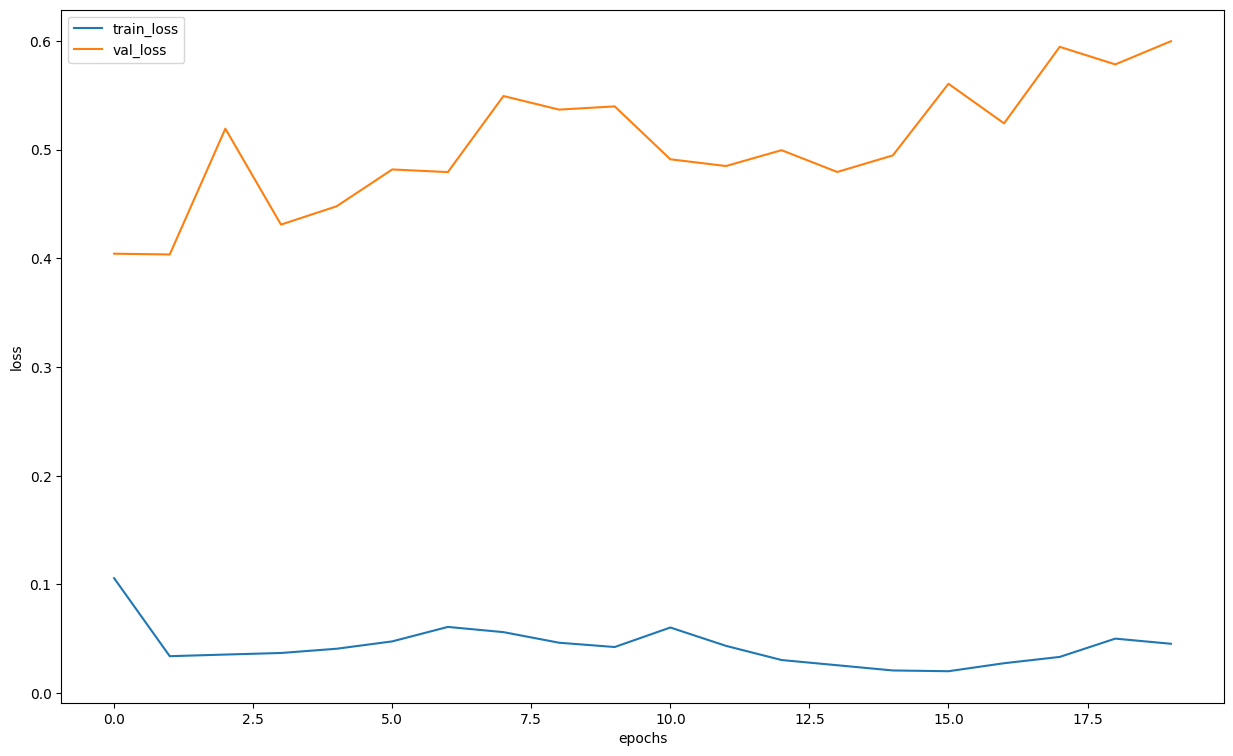

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

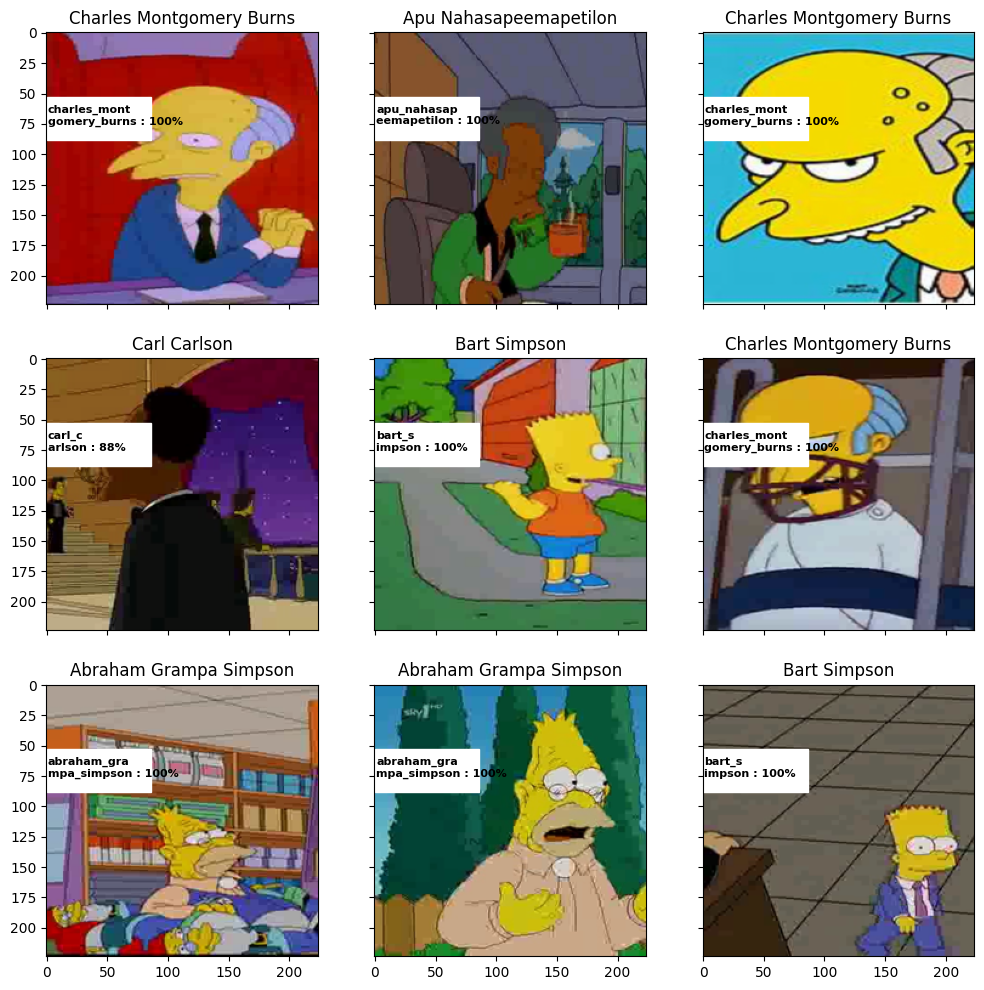

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls

data	label_encoder.pkl  sample_data
gdrive	model.torch	   simple_cnn_baseline.csv


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_submission.csv'

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
num_files = np.array(
    list(map(lambda n: int(n[3:n.index('.')]), test_filenames))
    )
sort_nums = np.argsort(num_files)
pd.DataFrame(
    {'Id': np.array(test_filenames)[sort_nums],
     'Expected': np.array(preds)[sort_nums]}
    ).to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:
1. Работа с датасетом:
* проверка (EDA) и предобработка;
* дополнение, выравниванике кол-ва картинок в классах - изменять можно как сами картинки, формируя новый датасет, или в класссе SimpsonsDataset;
* с помощью [аугментации](https://habr.com/ru/companies/smartengines/articles/264677/) или [без](https://www.geeksforgeeks.org/python-data-augmentation/);

2. Рабта с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных слоёв;
* кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять!

3. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

4. Файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

5. Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
